In [115]:
import typing
import numpy as np
import cv2 as cv
import os, json
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from numba import jit, njit

import logging

numba_logger = logging.getLogger("numba")
numba_logger.setLevel(logging.WARNING)

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [116]:
RUN_EXAMPLES = False


class StopExecution(Exception):
    def _render_traceback_(self):
        pass


class Example:
    def __init__(self) -> None:
        if not RUN_EXAMPLES:
            raise StopExecution

# Function Definitions and Examples

In the first half of this notebook we present some helpful functions that we later use in our processing pipeline

## ProcessImageConfig

to process the image, we use an **ProcessImageConfig**, which contains information about what the 4 colors are in the image approximately:
- cell_color: e.g. black
- background_color: e.g. purple
- marker1_color: e.g. red
- marker2_color: e.g. green

Alternatively these can be obtained by performing clustering, maybe meanshift?

In [117]:
ColorF = Tuple[float, float, float]
ColorI = Tuple[float, float, float]
# as rgb floats [0.0 to 1.0]


@dataclass
class ProcessImageConfig:
    """all values in HSL integers"""

    background_color: ColorF
    cell_color: ColorF
    marker1_color: ColorF
    marker2_color: ColorF

    def show(self):
        im = np.zeros((100, 400, 3), np.float32)
        im[:, :100, :] = self.background_color
        im[:, 100:200, :] = self.cell_color
        im[:, 200:300, :] = self.marker1_color
        im[:, 300:, :] = self.marker2_color
        plt.imshow(im)
        plt.show()

    @staticmethod
    def from_ints(
        background_color: ColorI,
        cell_color: ColorI,
        marker1_color: ColorI,
        marker2_color: ColorI,
    ):
        x = lambda c: (float(c[0]) / 255.0, float(c[1]) / 255.0, float(c[2]) / 255.0)
        return ProcessImageConfig(
            background_color=x(background_color),
            cell_color=x(cell_color),
            marker1_color=x(marker1_color),
            marker2_color=x(marker2_color),
        )


def infer_config_from_image(image: cv.Mat) -> ProcessImageConfig:
    raise "not implemented"  # type: ignore



DISH1_CONFIG = ProcessImageConfig.from_ints(
    background_color=(193, 198, 189),
    cell_color=(161, 176, 194),
    marker1_color=(136, 22, 161),
    marker2_color=(84, 52, 151),
)
Example()
DISH1_CONFIG.show()

## Preprocessing
(encompasses all things that do not need any ProcessImageConfig values)

1. blurring the image to get rid of noise

In [118]:
def imread(path: str) -> cv.Mat:
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.normalize(img, img, 0, 1, cv.NORM_MINMAX, cv.CV_32F)
    return img


def imshow(img: cv.Mat) -> None:
    if img.shape.__len__() == 3:
        plt.imshow(img)
        plt.show()
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_GRAY2RGB))
        plt.show()


def preprocess_image(image: cv.Mat) -> cv.Mat:
    image = cv.blur(image, (10, 10))
    return image


Example()

img = imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")
imshow(img)
processed = preprocess_image(img)
imshow(processed)

## Finding the cell/background separation

The next step is to make a distinction between cells and background.

For this we can calculate the distance from every pixels color to cell color vs. background color. The closest distance decides if this is black in the mask (background) or white (cells)

In [119]:
@njit(inline="always")
def rgbsqrdist(
    r1: float, g1: float, b1: float, r2: float, g2: float, b2: float
) -> float:
    return (r1 - r2) * (r1 - r2) + (b1 - b2) * (b1 - b2) + (g1 - g2) * (g1 - g2)


@jit
def fore_ground_soft_mask(img: cv.Mat, config: ProcessImageConfig) -> cv.Mat:
    output = img.copy()[:, :, 0]
    output[:, :] = 0
    height, width = img.shape[0], img.shape[1]

    bg_r = config.background_color[0]
    bg_g = config.background_color[1]
    bg_b = config.background_color[2]

    cell_r = config.cell_color[0]
    cell_g = config.cell_color[1]
    cell_b = config.cell_color[2]

    m1_r = config.marker1_color[0]
    m1_g = config.marker1_color[1]
    m1_b = config.marker1_color[2]

    m2_r = config.marker2_color[0]
    m2_g = config.marker2_color[1]
    m2_b = config.marker2_color[2]

    for i in range(height):
        for j in range(width):
            r = img[i, j, 0]
            g = img[i, j, 1]
            b = img[i, j, 2]
            bg_dist = rgbsqrdist(r, g, b, bg_r, bg_g, bg_b)
            cell_dist = rgbsqrdist(r, g, b, cell_r, cell_g, cell_b)
            m1_dist = rgbsqrdist(r, g, b, m1_r, m1_g, m1_b)
            m2_dist = rgbsqrdist(r, g, b, m2_r, m2_g, m2_b)

            cell_dist = min(cell_dist, m1_dist, m2_dist)

            output[i, j] = bg_dist / (bg_dist + cell_dist)
    return output


@jit
def versus_soft_mask(img: cv.Mat, black: ColorF, white: ColorF) -> cv.Mat:
    output = img.copy()[:, :, 0]
    output[:, :] = 0
    height, width = img.shape[0], img.shape[1]

    black_r = black[0]
    black_g = black[1]
    black_b = black[2]

    white_r = white[0]
    white_g = white[1]
    white_b = white[2]

    for i in range(height):
        for j in range(width):
            r = img[i, j, 0]
            b = img[i, j, 2]
            g = img[i, j, 1]
            black_dist = rgbsqrdist(r, g, b, black_r, black_g, black_b)
            white_dist = rgbsqrdist(r, g, b, white_r, white_g, white_b)

            output[i, j] = black_dist / (black_dist + white_dist)
    return output


def threshold(img: cv.Mat, thresh: float) -> cv.Mat:
    value, mat = cv.threshold(img, thresh, 1.0, cv.THRESH_BINARY)
    return mat


def multiblur(
    img: cv.Mat,
    iterations: int = 100,
    boost: float = 1.03,
    size: Tuple[int, int] = (20, 20),
):
    img = img
    for i in range(iterations):
        img = cv.blur(img, size) * boost
    return img


# def vs_mask(img: cv.Mat, black: ColorF, white: ColorF):


Example()

img = imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")
img = preprocess_image(img)
config = DISH1_CONFIG
mask = fore_ground_soft_mask(img, config)
imshow(mask)
mask = threshold(mask, 0.5)
imshow(mask)

markers = versus_soft_mask(img, config.background_color, config.marker1_color)
imshow(markers)

markers = threshold(markers, 0.8)
imshow(markers)

blurred_markers = multiblur(markers)
imshow(blurred_markers)

# Defining our processing pipeline

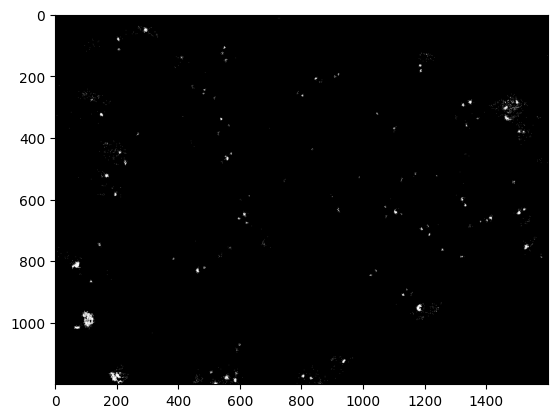

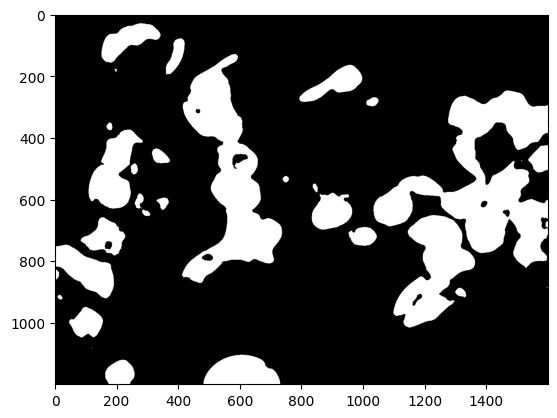

In [139]:
def process_image(img: cv.Mat, config: ProcessImageConfig):
    """gets a f32 rgb image and a processing config as input and produces a mask image that reflects the classification result"""
    INITAL_MASK_TRESH = 0.5
    MARKER1_THRESH = 0.8
    MARKER2_THRESH = 0.9

    # separate foreground and background:
    mask = fore_ground_soft_mask(img, config)
    mask = threshold(mask, INITAL_MASK_TRESH)
    # find markers1 (e.g. red dots) and apply threshold to suppress low values. Then blur to spread radius
    markers1 = versus_soft_mask(img, config.background_color, config.marker1_color)
    markers1 = threshold(markers1, MARKER1_THRESH)
    markers1 = multiblur(markers, iterations=100, boost=1.025, size=(20, 20))

    # find markers2 (e.g. green dots) and apply threshold to suppress low values. Then blur to spread radius
    markers2 = versus_soft_mask(img, config.background_color, config.marker2_color)
    markers2 = threshold(markers2, MARKER2_THRESH)
    imshow(markers2)
    markers2 = multiblur(markers2, iterations=100, boost=1.025, size=(20, 20))

    # intersect_m1 = np.minimum(mask, markers1)
    # imshow(threshold(intersect_m1, 0.025))
    # intersect_m2 = np.minimum(mask, markers2)
    # imshow(threshold(intersect_m2, 0.025))
    # union = np.maximum(intersect_m1, intersect_m2)
    # union = threshold(union, 0.025)
    # union = threshold(union, 0.5)
    e = threshold(multiblur(threshold(np.minimum(mask, markers1), 0.02), 1), 0.5)
    return e


img = imread("data/sampleinput/DISH1/125121A_S20200928_0014.jpg")
res = process_image(img, DISH1_CONFIG)
imshow(res)

## Evaluation

In [140]:
from typing import Any
from shapely.geometry import Polygon, Point, MultiPoint


class AnnotationPoly:
    """A polygon from a list of points"""

    points: List[Tuple[float, float]]
    _polygon: Polygon
    center: Tuple[float, float]
    area: float
    # (y, x) points of the surrounding
    def __init__(self, points: List[Tuple[float, float]]) -> None:
        self.points = points
        self._polygon = Polygon(self.points)

        center_point: Point = self._polygon.centroid
        self.center = (center_point.x, center_point.y)
        self.area = self._polygon.area

    @staticmethod
    def from_json(json: Dict[str, Any]):
        xes = [float(s) for s in json["Points"][0]["X"].split(",")]
        yes = [float(s) for s in json["Points"][0]["Y"].split(",")]
        return AnnotationPoly([(x, y) for (x, y) in zip(xes, yes)])

    def bounds_size(self) -> Tuple[float, float]:
        """returns (height,width) of the area enclosed"""
        minx, miny, maxx, maxy = self._polygon.bounds
        return (maxy - miny, maxx - minx)

    def bounds_avg_size(self):
        h, w = self.bounds_size()
        return (h + w) / 2

    def contains_point(self, point: Tuple[float, float]):
        return Point(point[1], point[0]).within(self._polygon)
        # self._polygon.within()

    def resize(self, resize_factor: float):
        new_points = [(y * resize_factor, x * resize_factor) for (y, x) in self.points]
        return AnnotationPoly(new_points)


class SampleImage:
    transformed: None | cv.Mat
    image: cv.Mat

    def __init__(self, partial_path: str) -> None:
        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        self.image = imread(jpg_path)


class LabelInformation:
    annotations: List[AnnotationPoly]
    name: str
    image_size: Tuple[int, int]  # (h, w)

    def __init__(self, partial_path: str) -> None:
        """expects partial_path to be like: "DISH1/125121A_S20200928_0014"
        - looks for data/reference/DISH1/125121A_S20200928_0014/ndmctsgh.json
        - looks for data/sampleinput/DISH1/125121A_S20200928_0014.jpg
        """
        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        json_path = f"data/reference/{partial_path}/ndmctsgh.json"
        self.name = partial_path

        # read metadata from json
        f = open(json_path)
        j = json.load(f)
        f.close()
        annotations = []
        for a in j["annotations"]:
            annotations.append(AnnotationPoly.from_json(a))
        self.annotations = annotations

        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        image = imread(jpg_path)
        self.image_size = (image.shape[0], image.shape[1])

In [ ]:
all_partial_paths = [
    # "TEST/test"
    "DISH1/125121A_S20200928_0014",
    "DISH1/125121A_S20200928_0017",
    "DISH1/1931427A_S20200928_0005",
    "DISH1/1931427A_S20200928_0014",
    "DISH1/2004994A_S20201013_0001",
    "DISH2/1(2)",
    "DISH2/5(2)",
    "DISH2/DISH3",
    "DISH2/P002120277A-2",
    "DISH2/P002124864A-1",
    "FISH/12-09-12P0012201890-2",
    "FISH/12-09-12P0012201893-1",
    "FISH/12-09-13P001220195-1",
    "FISH/P001506473(P001805365A)-1",
    "FISH/P001531546(P001529027C)9",
]


def process_and_evaluate_image(partial_path: str):
    label_information = LabelInformation(partial_path)
    sample_image = SampleImage(partial_path)
    print(label_information.image_size)


process_and_evaluate_image(all_partial_paths[0])